# Multivariate Classic ML Methods

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib


## 1. Load the Dataset

In [15]:
# Load the processed dataset
file_path = r"C:\Users\axxiv\Desktop\PI\mm-5G-forecast-ready.csv"
dataset = pd.read_csv(file_path)

# Display dataset information
print("Dataset Loaded Successfully!\n")
print(dataset.info())


Dataset Loaded Successfully!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68118 entries, 0 to 68117
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   run_num               68118 non-null  float64
 1   seq_num               68118 non-null  float64
 2   abstractSignalStr     68118 non-null  float64
 3   latitude              68118 non-null  float64
 4   longitude             68118 non-null  float64
 5   movingSpeed           68118 non-null  float64
 6   compassDirection      68118 non-null  float64
 7   nrStatus              68118 non-null  int64  
 8   lte_rssi              68118 non-null  float64
 9   lte_rsrp              68118 non-null  float64
 10  lte_rsrq              68118 non-null  float64
 11  lte_rssnr             68118 non-null  float64
 12  nr_ssRsrp             68118 non-null  float64
 13  nr_ssRsrq             68118 non-null  float64
 14  nr_ssSinr             68118 non-null  fl

## 2. Define parameters for rolling window

In [16]:
# Define the target and features
target = 'Throughput'
features = dataset.drop(columns=[target]).columns

# Rolling window configuration
window_size = 50   # Number of observations for each input window
horizon = 10       # Steps ahead to forecast
step_size = 5      # Step to move the window

print(f"\nRolling Window Parameters:\nWindow Size: {window_size}, Horizon: {horizon}, Step Size: {step_size}")



Rolling Window Parameters:
Window Size: 50, Horizon: 10, Step Size: 5


## 3. Create Rolling Window

In [17]:
# Function to create rolling windows
def create_rolling_windows(data, window_size, horizon, step_size):
    X_windows, y_windows = [], []
    for start in range(0, len(data) - window_size - horizon + 1, step_size):
        end = start + window_size
        horizon_end = end + horizon
        
        X = data.iloc[start:end][features].values
        y = data.iloc[end:horizon_end][target].values

        # Ensure the horizon has enough data points
        if len(y) == horizon:
            X_windows.append(X)
            y_windows.append(y)
    
    return np.array(X_windows), np.array(y_windows)

# Generate rolling windows
X_windows, y_windows = create_rolling_windows(dataset, window_size, horizon, step_size)


## 4.Display and verify rolling windows

In [6]:
# Display summary information
print(f"\nTotal Rolling Windows Created: {len(X_windows)}")
print(f"Shape of X_windows: {X_windows.shape}  # (num_windows, window_size, num_features)")
print(f"Shape of y_windows: {y_windows.shape}  # (num_windows, horizon)")

# Display the first input and target window for manual verification
print("\nFirst Input Window (X):")
print(X_windows[0])

print("\nFirst Target Window (y):")
print(y_windows[0])



Total Rolling Windows Created: 13612
Shape of X_windows: (13612, 50, 21)  # (num_windows, window_size, num_features)
Shape of y_windows: (13612, 10)  # (num_windows, horizon)

First Input Window (X):
[[0.         0.         0.25       ... 1.         1.         1.        ]
 [0.         0.00125156 0.25       ... 1.         1.         1.        ]
 [0.         0.00250313 0.25       ... 1.         1.         1.        ]
 ...
 [0.         0.05882353 0.75       ... 0.         0.         0.        ]
 [0.         0.06007509 0.75       ... 0.         0.         0.        ]
 [0.         0.06132666 0.75       ... 0.         0.         0.        ]]

First Target Window (y):
[0.06302083 0.06197917 0.0640625  0.053125   0.05520833 0.059375
 0.05520833 0.04322917 0.05833333 0.0546875 ]


In [18]:
# Split the data into training and testing (no shuffle for time-series)
X_train, X_test, y_train, y_test = train_test_split(
    X_flattened, y_flattened, test_size=0.2, shuffle=False
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (10889, 1050), y_train shape: (10889, 10)
X_test shape: (2723, 1050), y_test shape: (2723, 10)


## 3. Split Data into Training and Testing Sets

In [29]:
# Split the data into training and testing (no shuffle for time-series)
X_train, X_test, y_train, y_test = train_test_split(
    X_flattened, y_flattened, test_size=0.2, shuffle=False
)

# Export the flattened data to .npy files
np.save(r"C:\Users\axxiv\Desktop\PI\X_flattened.npy", X_flattened)
np.save(r"C:\Users\axxiv\Desktop\PI\y_flattened.npy", y_flattened)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (10889, 1050), y_train shape: (10889, 10)
X_test shape: (2723, 1050), y_test shape: (2723, 10)


## Define and train multi-Output models models

In [19]:
# Function to wrap the model for multi-output regression
def wrap_model(model):
    return MultiOutputRegressor(model, n_jobs=-1)  # Enables parallel training for each target

# Define models with MultiOutputRegressor
models = {
    'Linear Regression': wrap_model(LinearRegression()),
    'Decision Tree': wrap_model(DecisionTreeRegressor()),
    'Random Forest': wrap_model(RandomForestRegressor(n_estimators=20, max_depth=10, max_features='sqrt', n_jobs=-1)),
    'Gradient Boosting': wrap_model(GradientBoostingRegressor(n_estimators=30)),
    'XGBoost': wrap_model(xgb.XGBRegressor(n_estimators=30, objective='reg:squarederror', n_jobs=-1))
}

# Train and store models
trained_models = {}
for name, model in models.items():
    print(f"\nTraining {name} for multi-output forecasting...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} training complete.")



Training Linear Regression for multi-output forecasting...
Linear Regression training complete.

Training Decision Tree for multi-output forecasting...
Decision Tree training complete.

Training Random Forest for multi-output forecasting...
Random Forest training complete.

Training Gradient Boosting for multi-output forecasting...
Gradient Boosting training complete.

Training XGBoost for multi-output forecasting...
XGBoost training complete.


## Evaluate models

In [20]:
# Dictionary to store evaluation results
model_results = {}

# Function to evaluate models and store results
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results in the dictionary
    model_results[name] = {
        'model': model,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }
    
    # Print evaluation metrics
    print(f"{name} => MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    return mse

# Evaluate all trained models
for name, model in trained_models.items():
    evaluate_model(name, model, X_test, y_test)

Linear Regression => MSE: 0.0410, MAE: 0.1573, R2: 0.2664
Decision Tree => MSE: 0.0669, MAE: 0.1832, R2: -0.1973
Random Forest => MSE: 0.0341, MAE: 0.1472, R2: 0.3896
Gradient Boosting => MSE: 0.0351, MAE: 0.1440, R2: 0.3721
XGBoost => MSE: 0.0361, MAE: 0.1447, R2: 0.3549


In [22]:
# Find the model with the lowest MSE
best_model_name = min(model_results, key=lambda x: model_results[x]['mse'])
best_model = model_results[best_model_name]['model']
best_mse = model_results[best_model_name]['mse']

# Save the best model
save_path = r"C:\Users\axxiv\Desktop\PI\bestclassicalmodel.pkl"
joblib.dump(best_model, save_path)

print(f"\n✅ Best Model: {best_model_name}")
print(f"✅ Best Model MSE: {best_mse:.4f}")
print(f"✅ Model saved successfully at: {save_path}")


✅ Best Model: Random Forest
✅ Best Model MSE: 0.0341
✅ Model saved successfully at: C:\Users\axxiv\Desktop\PI\bestclassicalmodel.pkl


## 5. Test-Prediction Comparision

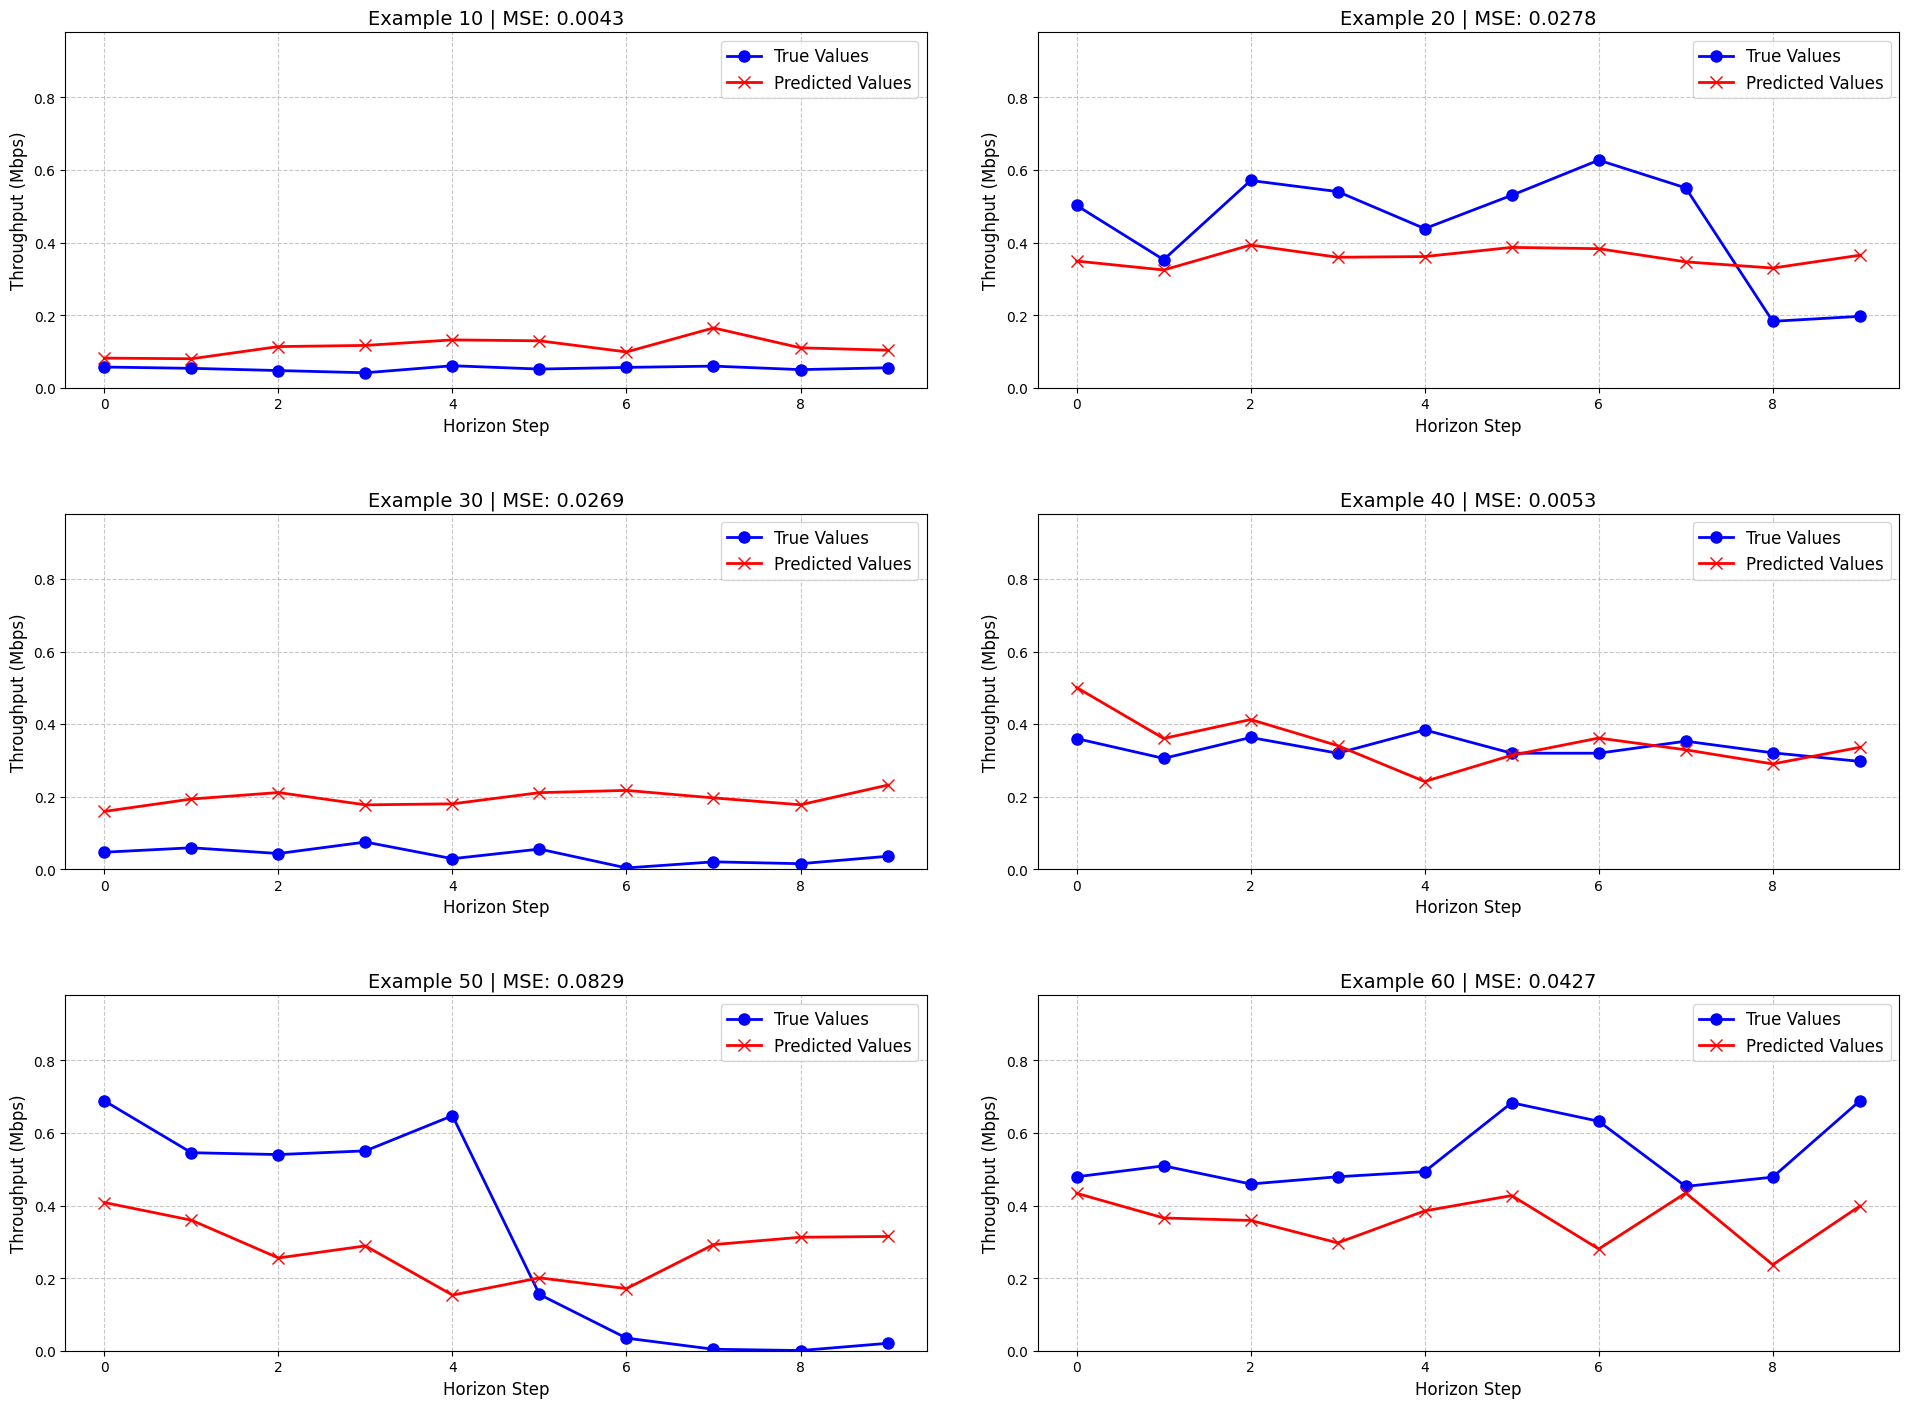

In [26]:
# Load the saved best classical model
model = joblib.load(r"C:\Users\axxiv\Desktop\PI\bestclassicalmodel.pkl")

# Define the indices to visualize
test_indices = [10, 20, 30, 40, 50, 60]

# Define the maximum throughput for scaling (replace with actual if known)
max_throughput = np.max(y_test)

# Set larger figure size for better clarity
plt.figure(figsize=(20, 15))

for i, n in enumerate(test_indices):
    # Prepare the input and true values
    x_in = X_test[n].reshape(1, -1)
    y_true = y_test[n]
    
    # Predict and flatten the output
    y_pred = model.predict(x_in).flatten()
    
    # Plot for this example
    plt.subplot(3, 2, i + 1)
    plt.plot(y_true * max_throughput, 'b', marker='o', markersize=8, linewidth=2, label='True Values')
    plt.plot(y_pred * max_throughput, 'r', marker='x', markersize=8, linewidth=2, label='Predicted Values')
    plt.ylim(0, max_throughput)
    plt.title(f"Example {n} | MSE: {mean_squared_error(y_true, y_pred):.4f}", fontsize=14)
    plt.xlabel('Horizon Step', fontsize=12)
    plt.ylabel('Throughput (Mbps)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend to all plots for clarity
    plt.legend(fontsize=12)

# Adjust spacing between subplots for clarity
plt.tight_layout(pad=4)
plt.show()

## 6. Evaluate MAE and RMSE

In [28]:
# Load the saved best classical model
model = joblib.load(r"C:\Users\axxiv\Desktop\PI\bestclassicalmodel.pkl")

# Define the maximum throughput for scaling (replace with actual if known)
max_throughput = np.max(y_test)

# Initialize lists to store errors
mae_list = []
mse_list = []

# Calculate errors for each test example
for x, y in zip(X_test, y_test):
    x_in = x.reshape(1, -1)                # Reshape input for prediction
    y_pred = model.predict(x_in).flatten()  # Predict and flatten output
    
    # Calculate MAE and MSE for the current example
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    # Store errors
    mae_list.append(mae)
    mse_list.append(mse)

# Convert to numpy arrays and calculate mean errors
MAE = np.mean(mae_list)
MSE = np.mean(mse_list)

# Print the final results in Mbps, scaling back to original units
print(f'MAE: {MAE * max_throughput:.1f} Mbps')
print(f'RMSE: {np.sqrt(MSE) * max_throughput:.1f} Mbps')

C:\Users\axxiv\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\axxiv\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MAE: 0.1 Mbps
RMSE: 0.2 Mbps
